In [1]:
import sys
SIM_PATH = "/home/luting/projects/sc_simulator"
sys.path.append(SIM_PATH) # simulator 项目的绝对路径
from simulator.hiererchical_simulator import *
from CME.CME_func import *
from figure_3a.curr_method_test import *
from figure_3a.tools import *
sys.path.append("/home/luting/projects/TAMER/MULE") # TAMER 项目的绝对路径
import mule as mu

import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from collections import defaultdict

# from anticor_features.anticor_features import get_anti_cor_genes
# import singleCellHaystack as hs
# import giniclust3 as gc
# from SEMITONES.cell_selection import from_knn_dist
# from SEMITONES.enrichment_scoring import calculate_escores
# from SEMITONES.enrichment_scoring import permute
# from SEMITONES.enrichment_scoring import sig_interval
# from SEMITONES.support_funcs import pairwise_similarities
# from SEMITONES.support_funcs import sig_dictionary

/home/luting/.local/lib/python3.8/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


Import MULE already


# 模拟数据

In [2]:
np.random.seed(2025)

Parsing xml tree file...
Generating alpha matrix...


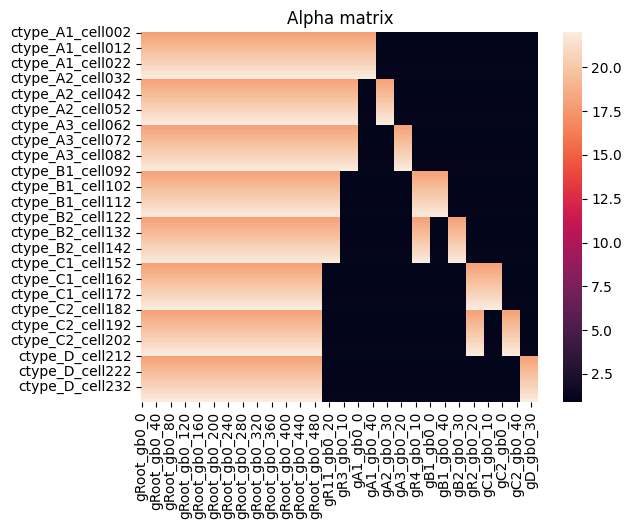

Sampling p's from Dirichlet distribution...
Sampling cell total UMIs from logNormal distribution...
A1 10 0.3
A2 10 0.3
A3 10 0.3
B1 10 0.3
B2 10 0.3
C1 10 0.3
C2 10 0.3
D 10 0.3
Sampling cells from multinomial distribution...


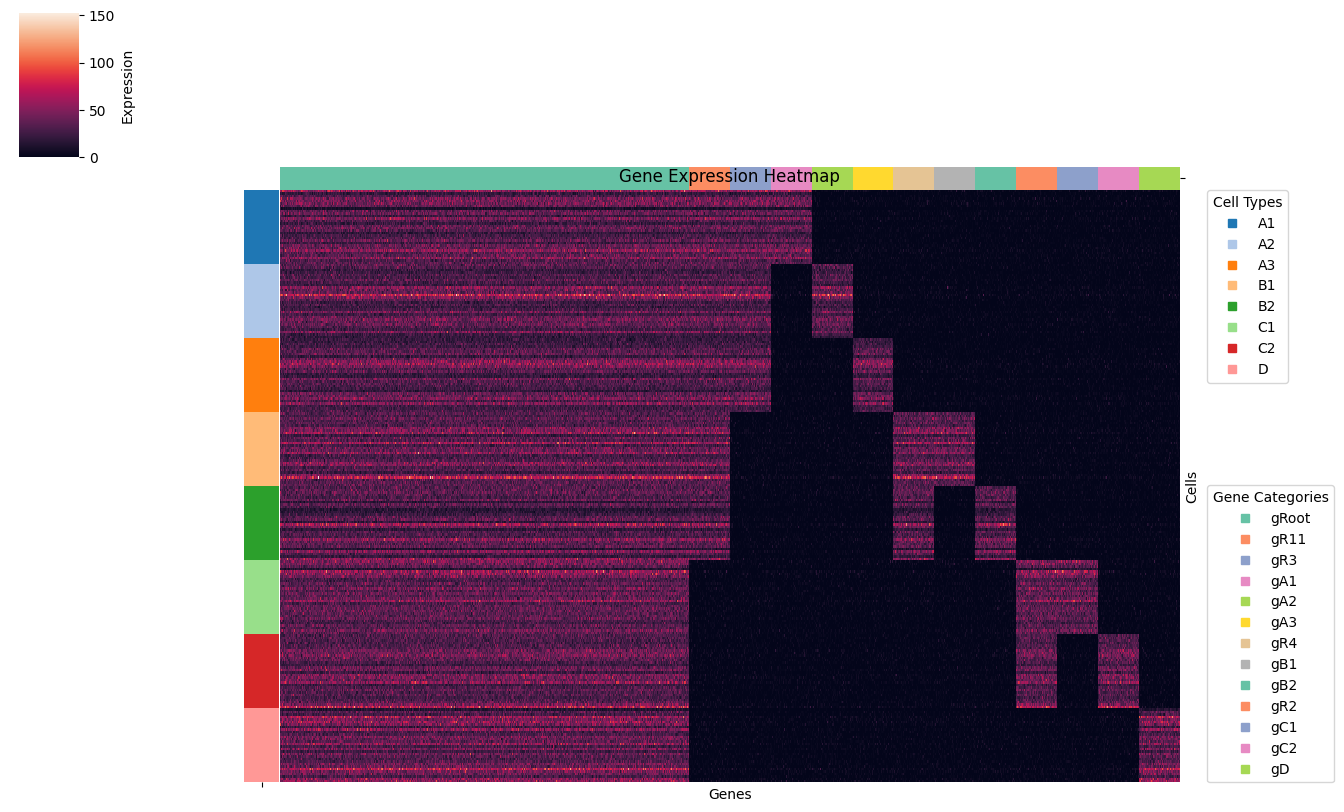

Saving anndata to: /home/luting/projects/sc_simulator/sim_data/adata/adata_17.h5ad


In [3]:
tree_dir = SIM_PATH + "/sim_data/trees"
data_dir = SIM_PATH + "/sim_data/adata"
data_df, adata = get_data_and_visualize(tree_id=17, tree_dir=tree_dir, data_dir=data_dir)

In [4]:
entropy_score = imbalance_entropy(adata, key='cell_type')
print("Entropy score:", entropy_score)

Cell type counts: cell_type
A1    30
A2    30
A3    30
B1    30
B2    30
C1    30
C2    30
D     30
Name: count, dtype: int64
Entropy score: 2.0794415416798357


## 亚型

## Sunburnt 图

In [5]:
import plotly.graph_objects as go
import pandas as pd

# 假设 parse_tree_from_xml 已经定义，并且 TreeNode 类也已存在
xml_file = SIM_PATH + "/sim_data/trees/tree_12.xml"
root = parse_tree_from_xml(xml_file)


data = []

def get_leaf_count(node):
    """递归计算节点下所有叶子节点数量"""
    if not node.children:
        return node.val
    return sum(get_leaf_count(child) for child in node.children)

def get_tree_height(node):
    """递归计算树的最大高度"""
    if not node.children:
        return 1
    return 1 + max(get_tree_height(child) for child in node.children)

MAX_HEIGHT = get_tree_height(root)

def add_virtual_nodes(node, current_depth=1, parent_name=None):
    """
    递归生成 Sunburst 所需数据。
    给深度不足的叶子节点增加虚拟节点，保证所有叶子都在最外层。
    """
    node_val = get_leaf_count(node)
    
    # 当前节点数据
    entry = {
        "id": node.name,
        "parent": parent_name,
        "num_cells": node_val,
        "num_genes": getattr(node, "marker_count", 0),
        "tot_exp": sum(getattr(node, "marker_genes", {}).values()),
        "high_ratio": getattr(node, "high_ratio", 0),
        "mid_ratio": getattr(node, "mid_ratio", 0),
        "low_ratio": getattr(node, "low_ratio", 0),
    }
    data.append(entry)
    
    # 递归处理子节点
    if node.children:
        for child in node.children:
            add_virtual_nodes(child, current_depth + 1, node.name)
    else:
        # 叶子节点但未到最深层时，增加虚拟节点
        depth = current_depth
        parent = node.name
        while depth < MAX_HEIGHT:
            virtual_name = f"{node.name}_v{depth}"
            data.append({
                "id": virtual_name,
                "parent": parent,
                "num_cells": node_val,  # 虚拟节点沿用原叶子数量
                "num_genes": 0,
                "tot_exp": 0,
                "high_ratio": 0,
                "mid_ratio": 0,
                "low_ratio": 0
            })
            parent = virtual_name
            depth += 1

# 生成 DataFrame
add_virtual_nodes(root)
df = pd.DataFrame(data)

# 绘制 Sunburst
fig = go.Figure(go.Sunburst(
    labels=df['id'],
    parents=df['parent'],
    values=df['num_cells'],
    branchvalues='total',
    hoverinfo='label+value+percent parent'
))
fig.update_layout(margin=dict(t=10, l=10, r=10, b=10))
fig.show()



# 跑方法

## MULE

In [6]:
# 处理数据
def mule_process(adata, opposite_graph_threshold = 0.8, subgraph_threshold=3, merge_threshold=1):
    adata = adata.copy()
    # sc.pp.normalize_total(adata, target_sum=1e6)
    # sc.pp.log1p(adata)
    # sc.pp.scale(adata)
    mu.pre_process.hvg(adata)
    sns.heatmap(adata.X)
    adata = adata[:,adata.var['highly_variable'] == True]
    mu.tax.mutually_exclusively_detect_CME(adata)
    mu.vis.polar_score(adata)

    mu.tax.build_opposite_graph(adata, threshold = opposite_graph_threshold)
    mu.vis.graph_degree(adata)

    mu.tax.get_subgraph(adata,threshold=subgraph_threshold)
    mu.vis.merge_strategy(adata)

    mu.tax.bipartite_embedding_perm_fast(adata,merge_threshold=merge_threshold)
    mu.vis.oppo_filter_graph(adata)
    mu.vis.mode_graph(adata)

    mu.tax.build_taxonomy_tree(adata)
    mu.tax.cal_scpurity_cme_parallel(adata)

    mu.tax.mule_umap(adata, ['mode 0', 'mode 1'])
    sc.tl.score_genes(adata, gene_list=adata.uns['mule']['mode info']['mode 1'])
    sc.pl.embedding(adata, basis='X_umap_mule', color = 'score')

    tree = mu.vis.plot_taxonomy_tree(adata)
    Image(tree.create_png())

    return adata

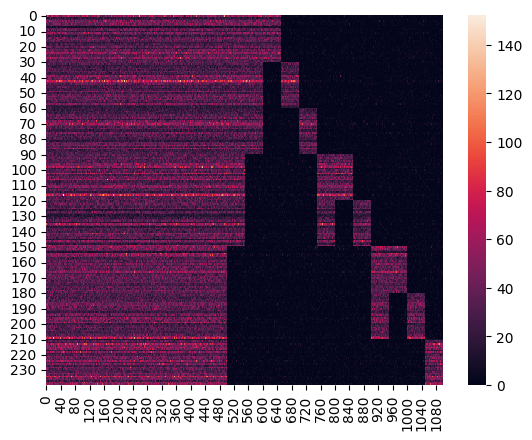

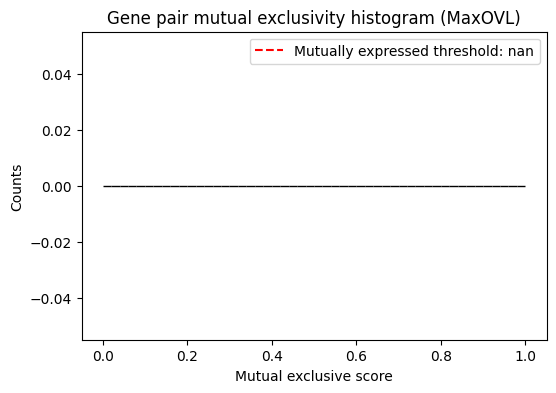

Build mutually exclusive gene graph
Calculate original graph degree


ZeroDivisionError: division by zero

In [7]:
adata_mule = mule_process(adata)
mule_genes = []
for mode in adata_mule.uns['mule']['mode info']:
    mule_genes = mule_genes + adata_mule.uns['mule']['mode info'][mode]


## Anti-Corr

In [8]:
def run_anticorrelation(adata):
    adata_copy = adata.copy()
    sc.pp.normalize_total(adata_copy)
    
    anti_cor_table = get_anti_cor_genes(
        adata_copy.X.T,
        adata_copy.var.index.tolist(),
        species="hsapiens",
        pre_remove_pathways=[],
        FPR=0.0002,
        FDR=1/40
    )
    selected_table = anti_cor_table[anti_cor_table["selected"]==True]
    return {
        "genes": selected_table.index.to_numpy(),
        "scores": -np.array(selected_table['FDR'].to_list())
    }

## GiniClust

In [9]:
def run_gini(adata):
    adata_copy = adata.copy()
    sc.pp.log1p(adata_copy)
    gc.gini.calGini(adata_copy, min_gini_value=0.1, neighbors=3, p_value=0.05)
    return {
        "genes": adata_copy.var.index.to_numpy(),
        "scores": adata_copy.var['gini_value'].values
    }

## scHayStack

In [10]:
def dimension_reduce(adata):
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=20)
    return adata

In [11]:
def run_haystack(adata):
    adata_copy = adata.copy()
    adata_copy.layers["counts"] = adata_copy.X.copy()
    sc.pp.normalize_total(adata_copy)
    sc.pp.log1p(adata_copy)
    adata_copy = dimension_reduce(adata_copy)
    res = hs.haystack(adata_copy, coord="X_pca")
    return {
        "genes": res.result.index.to_numpy(),
        "scores": -res.result['pval_adj'].values
    }

## semitones

In [12]:
def run_semitones(adata):
    """运行 Semitones 方法"""
    adata_copy = adata.copy()
    adata_copy.layers["counts"] = adata_copy.X.copy()
    sc.pp.normalize_total(adata_copy)
    sc.pp.log1p(adata_copy)
    adata_copy = dimension_reduce(adata_copy)

    S = pairwise_kernels(adata_copy.obsm['X_pca'], metric="rbf", gamma=8.6e-4)
    median = np.median(S, axis=0)
    start = int(np.argmin(median))

    dd_rcells = from_knn_dist(
        X=adata_copy.obsm['X_pca'],
        n_ret=17,
        start=start,
        metric_params={"gamma": 8.6e-4}
    )
    S = pairwise_similarities(adata_copy.obsm['X_pca'], query=dd_rcells, metric_params={"gamma": 8.6e-4})

    escores = calculate_escores(adata_copy.X, query=dd_rcells, S=S)
    return {
        "genes": adata_copy.var.index.to_numpy(),
        "scores": escores.max(axis=1)
    }

## DubStepR

In [13]:
def run_dubstepr(adata):
    data_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
    dubstepr_genes = analyze_gene_correlations(data_df, n_bins=15)
    return {
        "genes": dubstepr_genes
    }
# print(f"Found {len(dubstepr_genes)} genes with high correlation range")
# print("Selected genes:", dubstepr_genes)  # Print first 10 genes
# plot_cell_gene_heatmap(data_df, selected_genes, title='Cell-Gene Expression Heatmap\n(DubStepR Selected Genes in Yellow)')

## 可用方法列表

In [14]:
METHODS = {
    "Anti-correlation": run_anticorrelation,
    "Gini": run_gini,
    "Haystack": run_haystack,
    "Semitones": run_semitones,
    "DubStepR": run_dubstepr
}

In [15]:
def evaluate_methods(adata, method_names):
    """
    输入要运行的方法名称列表，输出 {方法名: {"genes": ..., "scores": ...}}
    """
    results = {}
    for name in method_names:
        if name not in METHODS:
            raise ValueError(f"方法 {name} 不在支持列表中: {list(METHODS.keys())}")
        print(f"Running {name} ...")
        results[name] = METHODS[name](adata)
    return results

# 对比

## Ground Truth

In [16]:
all_markers = [gene for gene in data_df.columns if not gene.startswith("gRoot")]
pattern = re.compile(r"^g(A1|A2|A3|B1|B2|C1|C2|D)")
subtype_markers = [gene for gene in data_df.columns if pattern.match(gene)]

## 雷达图

In [17]:
# 提取基因类别（属于什么 marker）
def extract_gene_category(gene_name):
        match = gene_name.split("_")
        if match:
            return match[0]
        return "Unknown"

gene_categories = [extract_gene_category(gene) for gene in adata.var_names]
gene_dict = defaultdict(list)
for category, gene_name in zip(gene_categories, adata.var_names):
    gene_dict[category].append(gene_name)

In [18]:
def split_dict_by_group(data):
    result = defaultdict(lambda: defaultdict(list))
    
    for key, values in data.items():
        for v in values:
            parts = v.split("_")
            if len(parts) > 1:
                group = parts[1]   # 比如 "gb0"
                result[group][key].append(v)
    
    return dict(result)

classed_dict = split_dict_by_group(gene_dict)

In [19]:
print("不同层：", classed_dict.keys())

# 选不同层的 dict
gene_dict = classed_dict['gb0']

不同层： dict_keys(['gb0'])


In [20]:
def radar_chart_from_method_results(method_results, gene_dict, adatas=None, method_colors=None):
    """
    画雷达图，每个角表示一个基因类别，值表示该方法在该类别中找出的基因比例。
    
    参数：
        method_results: dict
            每个 key 是方法名，每个 value 是 {'genes': [...], 'scores': [...]} 的 dict
        gene_dict: dict
            每个 key 是基因类别，value 是该类别的基因列表
        adatas: list of AnnData, optional
            每个方法对应的 AnnData（如果要根据实际选出的基因计算敏感性）
            如果 None，则直接用 method_results['genes'] 计算
        method_colors: list, optional
            每个方法的颜色
    """
    import matplotlib.pyplot as plt

    methods = list(method_results.keys())
    categories = list(gene_dict.keys())
    
    # 默认颜色
    if method_colors is None:
        default_colors = ['#1f77b4', '#d62728', '#2ca02c', '#9467bd', '#ff7f0e', '#17becf', '#8c564b']
        method_colors = [default_colors[i % len(default_colors)] for i in range(len(methods))]

    # 计算每个方法在每个类别的敏感性
    sensitivity_results = {}
    for i, method in enumerate(methods):
        method_genes = set(method_results[method]['genes'])
        sensitivity = []
        for category, gene_list in gene_dict.items():
            gene_list_set = set(gene_list)
            tp = len(gene_list_set & method_genes)
            num = len(gene_list_set)
            sensitivity.append(tp / num if num > 0 else 0)
        sensitivity_results[method] = sensitivity

    # 画雷达图
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # 闭合

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for i, method in enumerate(methods):
        values = sensitivity_results[method] + [sensitivity_results[method][0]]
        ax.plot(angles, values, 'o-', linewidth=1.5, label=method, color=method_colors[i], markersize=6)
        ax.fill(angles, values, alpha=0.05, color=method_colors[i])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
    ax.set_rlabel_position(30)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_yticklabels([f"{x:.1f}" for x in np.linspace(0, 1, 6)])
    ax.grid(alpha=0.3)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    plt.title("Gene Category Sensitivity Radar Chart", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


Running Anti-correlation ...
found 33.495445504 free Gb in /tmp
get_all_remove_genes
240 12
min_express_n 12
get_n_expressed


pre_remove_feature: 0
pre_remove_pathway: 0
pre_remove_low_express: 0
0  genes to remove out of  1100
rewriting the filtered dataset
/tmp/exprs.hdf5
total_vars: 1100
making the hdf5 spearman output file
/tmp/spearman.hdf5
Getting the Spearman correlations
total_vars 1100
empirically determined Cneg cutoff: -0.2390158165450582  for FPR of: 0.0002
empirically determined Cpos cutoff: 0.23718542997653316  for FPR of: 0.0002
get_real_spear
[0, 1100]
working on 0 1100 vs 0 1100
Running DubStepR ...


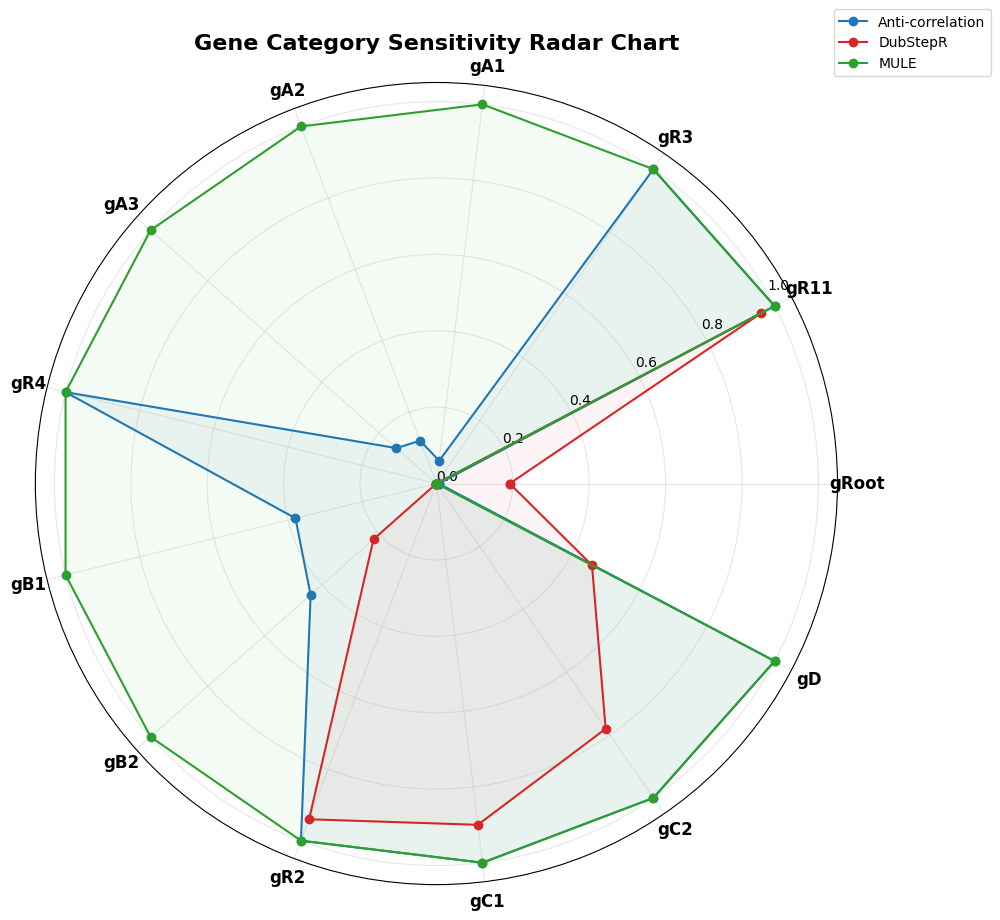

In [21]:
method_list = ["Anti-correlation", "DubStepR"]
results = evaluate_methods(adata, method_list)
results['MULE'] = {'genes': [gene for gene in adata.var_names if not gene.startswith("gRoot")]}
radar_chart_from_method_results(results, gene_dict)

## ROC 图

In [22]:
def ROC(label, method_results):
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    import numpy as np

    colors = ['darkorange', 'green', 'red', 'blue', 'purple', 'brown']
    names = list(method_results.keys())

    plt.figure(figsize=(8, 8))

    for i, name in enumerate(names):
        res = method_results[name]
        genes = res["genes"]
        scores = res["scores"]

        # 内部排序，按 score 降序排列基因
        sorted_indices = np.argsort(scores)[::-1]
        sorted_genes = [genes[j] for j in sorted_indices]
        sorted_scores = [scores[j] for j in sorted_indices]

        # 创建与 label 对齐的分数数组
        gene_to_score = dict(zip(sorted_genes, sorted_scores))
        scores_array = np.array([gene_to_score.get(g, 0) for g in adata.var_names])

        # 计算 ROC
        fpr, tpr, _ = roc_curve(label, scores_array)
        roc_auc = auc(fpr, tpr)

        # 画 ROC 曲线
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                 label=f'{name} (AUC = {roc_auc:.3f})')

        # 打印 AUC
        print(f"{name}: AUC = {roc_auc:.4f}")

    # 图形美化
    plt.axis('off')
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.legend(loc='lower right', frameon=True, fontsize=10, edgecolor='black')
    plt.tight_layout()
    plt.show()

Running Anti-correlation ...
found 33.495441408 free Gb in /tmp
get_all_remove_genes
240 12
min_express_n 12
get_n_expressed
pre_remove_feature: 0
pre_remove_pathway: 0
pre_remove_low_express: 0
0  genes to remove out of  1100
rewriting the filtered dataset
/tmp/exprs.hdf5


total_vars: 1100
making the hdf5 spearman output file
/tmp/spearman.hdf5
Getting the Spearman correlations
total_vars 1100
empirically determined Cneg cutoff: -0.24139808731577583  for FPR of: 0.0002
empirically determined Cpos cutoff: 0.23756686311719802  for FPR of: 0.0002
get_real_spear
[0, 1100]
working on 0 1100 vs 0 1100
Anti-correlation: AUC = 0.1662


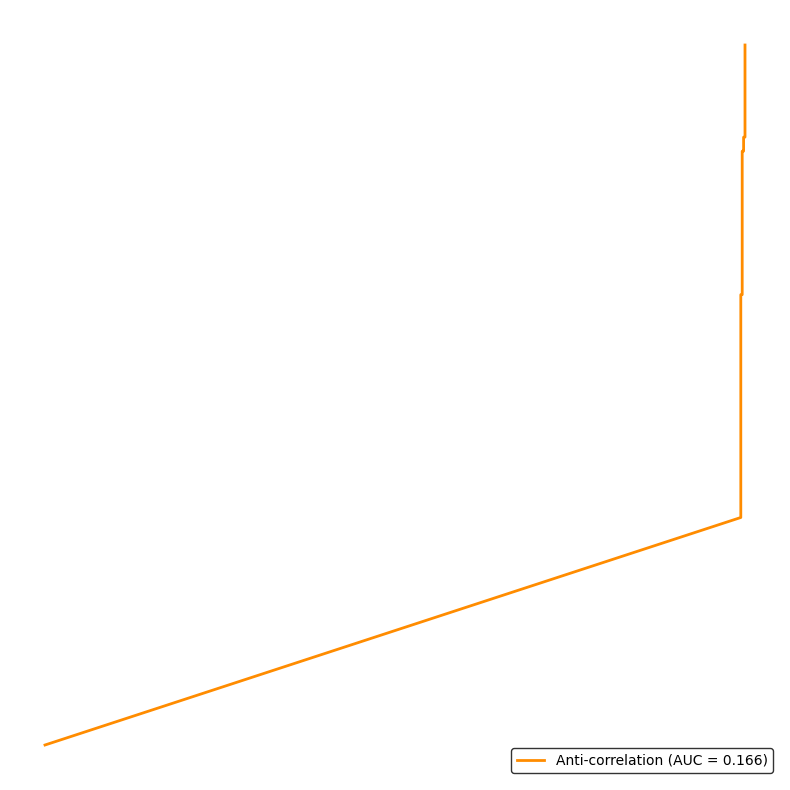

In [23]:
method_list = ["Anti-correlation"]
results = evaluate_methods(adata, method_list)

# ROC
label = [1 if g in all_markers else 0 for g in adata.var_names]
auc_dict = ROC(label, results)

# 取 gene list
anti_genes = results["Anti-correlation"]["genes"]

## UMAP

In [24]:
def plot_umap_by_method(adata, method_results, random_state=0):
    """
    为每个方法选出的基因绘制 UMAP。
    
    参数：
        adata: AnnData
            原始数据
        method_results: dict
            每个方法名对应 {'genes': [...], 'scores': [...]}
        random_state: int
            随机种子，用于 PCA/UMAP reproducibility
    """
    methods = list(method_results.keys())
    
    for method in methods:
        genes = method_results[method]['genes']
        
        # 保留原始 adata 不变
        adata_sub = adata[:, [g for g in genes if g in adata.var_names]].copy()
        
        # 标准化和 log1p（Scanpy 推荐流程）
        sc.pp.normalize_total(adata_sub)
        sc.pp.log1p(adata_sub)
        sc.pp.scale(adata_sub)
        
        # PCA + UMAP
        sc.tl.pca(adata_sub, svd_solver='arpack', random_state=random_state)
        sc.pp.neighbors(adata_sub, n_pcs=min(50, adata_sub.obsm['X_pca'].shape[1]))
        sc.tl.umap(adata_sub, random_state=random_state)
        
        # 绘图
        sc.pl.umap(adata_sub, color='cell_type', title=f"UMAP ({method})", show=True)

Running Anti-correlation ...
found 33.495437312 free Gb in /tmp
get_all_remove_genes
240 12
min_express_n 12
get_n_expressed
pre_remove_feature: 0
pre_remove_pathway: 0
pre_remove_low_express: 0
0  genes to remove out of  1100
rewriting the filtered dataset
/tmp/exprs.hdf5
total_vars: 1100
making the hdf5 spearman output file
/tmp/spearman.hdf5
Getting the Spearman correlations
total_vars 1100
empirically determined Cneg cutoff: -0.2380166526609653  for FPR of: 0.0002
empirically determined Cpos cutoff: 0.237694253061119  for FPR of: 0.0002
get_real_spear
[0, 1100]
working on 0 1100 vs 0 1100
Running DubStepR ...


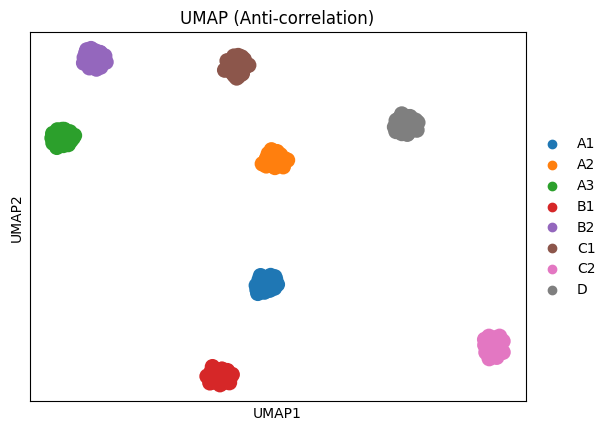

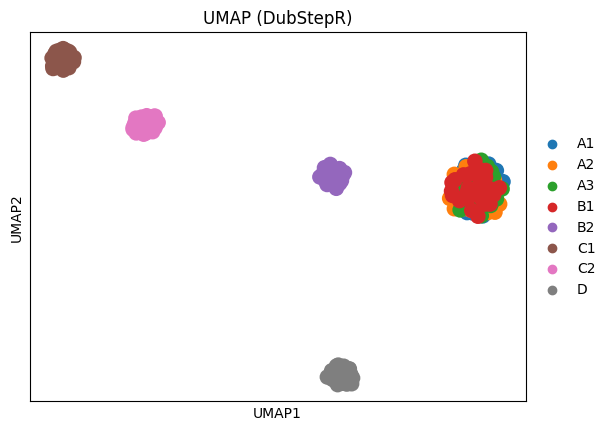

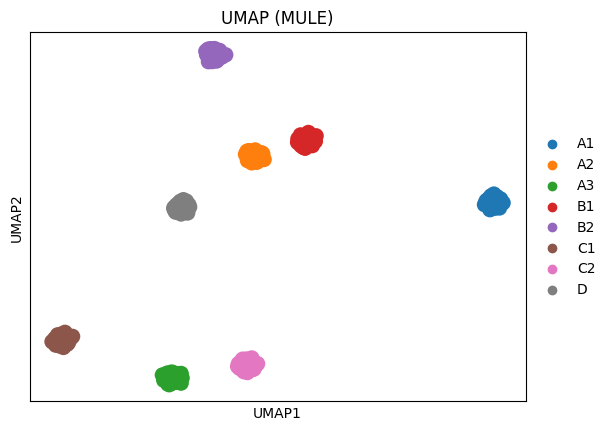

In [25]:
method_list = ["Anti-correlation", "DubStepR"]
results = evaluate_methods(adata, method_list)
results['MULE'] = {'genes': [gene for gene in adata.var_names if not gene.startswith("gRoot")]}
plot_umap_by_method(adata, results)